# 数据生成

## 生成测试数据

In [141]:
'''
处理流程  一：
1、 PDF文件
2、 通过 fitz 打开PDF，抽取文字，抽取图片
3、 生成数学公式图片，随机插入到图片中，并记录位置信息, 注意图片大小的问题

处理流程 二：
直接采用PIL的方式生成
'''
import lib.im2latex.gen_latex_img as lxu
import importlib
import lib.mathdetect.utils.pdfutils as pdf
import cv2
import random
from matplotlib import pyplot as plt 
# fig = plt.figure(figsize=(20,18))
importlib.reload(lxu)
importlib.reload(pdf)
'''
生成latex图片
'''

# print(limage.shape)
'''
PDF 文件处理， 通过 fitz 打开PDF，抽取文字及位置信息，抽取图片
'''
pdf_file = 'd:\\作业一：空气 氧气.pdf' # 注意只取一到6页
dir_name = 'huxue'
save_path = 'D:\\PROJECT_TW\\git\\data\\mathdetect\\data'
print(pdf.get_pdf_number(pdf_file))
page_numbers = pdf.get_pdf_number(pdf_file)
for idx  in range(6):
    print(f'begin {idx}')
    pdf.gen_test_pos_data(pdf_file,idx, save_path,dir_name,'gen')  
# pdf.gen_test_pos_data(pdf_file,1, 'd:\\test.png')
# def gen_test_pos_data(pdf_file, save_path):
#     latex_lists = lxu.random_latex(10)
#     limage = lxu.get_latex_image(latex_lists[0])
#     with open(pdf_file, 'rb') as f:
#         data=f.read()
#         pimage, ptext = pdf.pdf_convert_image(pdf_datas=data,page_height=1024,block_flag=True)
#     image = cv2.imdecode(np.frombuffer(pimage, np.uint8),cv2.IMREAD_COLOR)
#     latex_lists = lxu.random_latex(10)
#     limage_lists = [lxu.get_latex_image(x) for x in  latex_lists]
#     image, pos = pdf.batch_gen_image_pdf(image,ptext,limage_lists,size=random.randint(5,10))
#     cv2.imwrite('d:\\test.png', image)
# cv2.rectangle(image, (pos[0], pos[1]), (pos[2], pos[3]), (0, 255, 255), 1)
# plt.imshow(image)
# plt.show()


9
begin 0
begin 1
begin 2
begin 3
begin 4
begin 5


['Arial', 'Arial', 'Arial', 'Arial', 'Arial', 'Bahnschrift', 'Calibri', 'Calibri', 'Calibri', 'Calibri', 'Calibri', 'Calibri', 'Cambria', 'Cambria', 'Cambria', 'Cambria', 'Candara', 'Candara', 'Candara', 'Candara', 'Candara', 'Candara', 'Comic Sans MS', 'Comic Sans MS', 'Comic Sans MS', 'Comic Sans MS', 'Consolas', 'Consolas', 'Consolas', 'Consolas', 'Constantia', 'Constantia', 'Constantia', 'Constantia', 'Corbel', 'Corbel', 'Corbel', 'Corbel', 'Corbel', 'Corbel', 'Courier New', 'Courier New', 'Courier New', 'Courier New', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans', 'DejaVu Sans Display', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif', 'DejaVu Serif Display', 'DengXian', 'DengXian', 'DengXian', 'Ebrima', 'Ebrima', 'FangSong', 'Franklin Gothic Medium', 'Franklin Gothic Medium', 'Gabriola', 'Gadugi', 'Gadugi', 'Georgia', 'Georgia', 'Georgia', 'Georgia', 'Impact', 'Ink Free', 'J

In [64]:
import numpy as np
d =  np.random.randn(100,8)
# print(''.join(str(d[1:10,3].tolist())))
print(''.join([str(x) for x in d[1:10,3].tolist()]))
','.join([1,2])

-0.55882113784509120.34344642598893790.3515079855079526-0.8329992231648248-1.00662123942897890.50640834965895711.0816968849965662-1.1469912026982005-2.0346580763362256


TypeError: sequence item 0: expected str instance, int found

In [ ]:
'''
1、https://www.jianshu.com/p/f57cc64b9f5e PDF转图片
2、http://blog.alivate.com.au/poppler-windows/

'''

[[582 603 678 624]
 [157 583 176 601]
 [422 296 519 317]
 [340 273 372 294]
 [117 253 137 271]
 [178 211 198 228]
 [234 159 253 177]]
(1024, 792, 3)


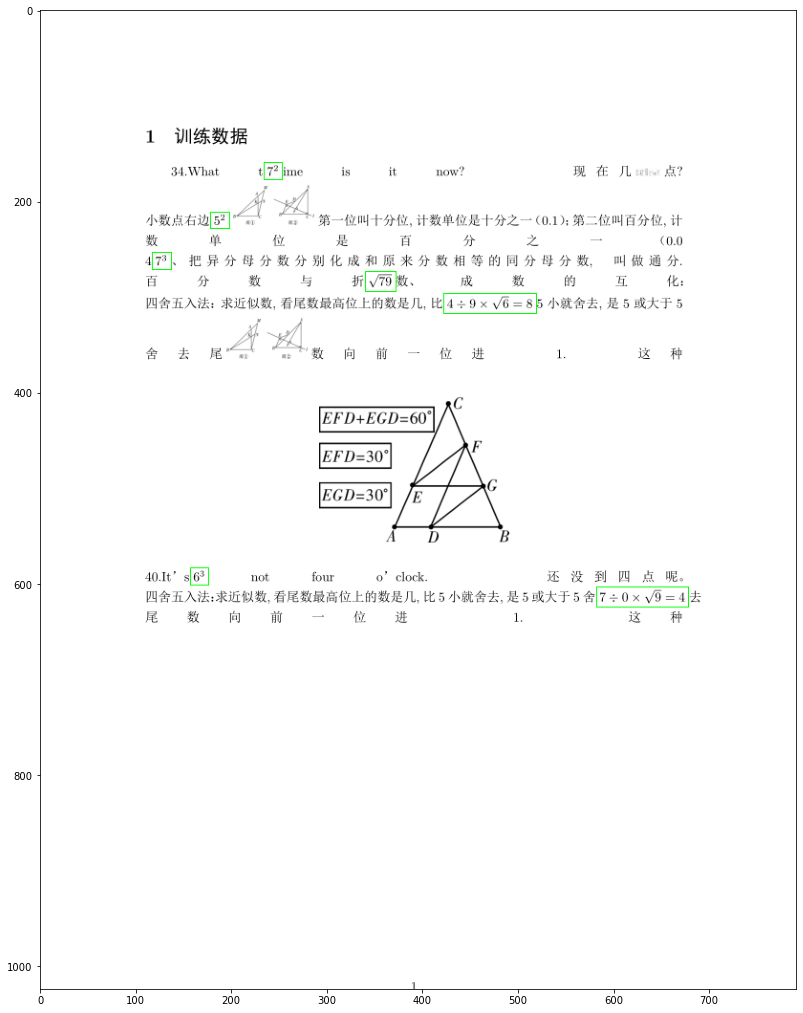

In [19]:
%matplotlib inline
import importlib
from matplotlib import pyplot as plt 
import cv2
import os
import numpy as np
# \\images\\autogen\\test.png
file_name = '21'
data_path = 'D:\\PROJECT_TW\\git\\data\\mathdetect\\data'
image_path = os.path.sep.join([data_path, 'images','autogen', f'{file_name}.png'])
anno_path = os.path.sep.join([data_path, 'annotations','autogen',f'{file_name}.pmath'])
fig = plt.figure(figsize=(20,18))
image = cv2.imread(image_path, cv2.IMREAD_COLOR) 

boxes = np.loadtxt(anno_path,dtype=np.int,delimiter=',')
print(boxes)
for item in boxes:
    x0,y0,x1,y1 = item
    cv2.rectangle(image, (x0,y0), (x1, y1), (0, 255, 0), 1)
# print('image size:', image.shape)
# cv2.rectangle(image, (408, 222), (424, 243), (0, 0, 255), 1)
# cv2.rectangle(image, (518, 199), (534, 220), (0, 0, 255), 1)
# cv2.rectangle(image, (284, 199), (299, 220), (0, 0, 255), 1)
# cv2.rectangle(image, (341, 197), (379, 218), (0, 0, 255), 1)
# cv2.rectangle(image, (1424, 4007), (1827, 4082), (0, 255, 255), 3)
# cv2.rectangle(image, (2402, 5669), (2857, 5752), (0, 255, 255), 3)
# cv2.rectangle(image, (1162, 4253), (1387, 4336), (0, 255, 255), 3)
# cv2.rectangle(image, (3918, 5665), (4009, 5734), (0, 255, 255), 3)
print(image.shape)
plt.imshow(image)
plt.show()



# 测试

In [1]:
import sys
sys.path.append('./lib/mathdetect')
from data import *
import ssd as ssd
import init as init
import importlib
importlib.reload(init)
args =init.init_args([])
# args.cfg = 'ssd300'
args.cfg = 'math_gtdb_512'
# weights_path = 'D:\\PROJECT_TW\\git\\data\\mathdetect\\ckpts\\weights_math_detector\\best_ssd300.pth'
weights_path = 'D:\\PROJECT_TW\\git\\data\\mathdetect\\ckpts\\weights_math_detector\\best_ssd512.pth'
# print(args)
cfg = exp_cfg[args.cfg]
print(cfg)
print(args.model_type)
# net = ssd.build_ssd(args, 'test', cfg, 0, 300, 3)
net = ssd.build_ssd(args, 'use', cfg, 0, 512, 3)
mod = torch.load(weights_path,map_location=torch.device('cpu'))
net.load_state_dict(mod)
net.eval()

{'num_classes': 3, 'lr_steps': (80000, 100000, 120000), 'max_iter': 240000, 'feature_maps': [64, 32, 16, 8, 4, 2, 1], 'min_dim': 512, 'steps': [8, 16, 32, 64, 128, 256, 512], 'min_sizes': [8.0, 76.8, 153.6, 230.4, 307.2, 384.0, 460.8], 'max_sizes': [76.8, 153.6, 230.4, 307.2, 384.0, 460.8, 537.6], 'aspect_ratios': [[2, 3, 5, 7, 10], [2, 3, 5, 7, 10], [2, 3, 5, 7, 10], [2, 3, 5, 7, 10], [2, 3, 5, 7, 10], [2, 3, 5, 7, 10], [2, 3, 5, 7, 10]], 'variance': [0.1, 0.2], 'clip': True, 'name': 'math_gtdb_512', 'is_vertical_prior_boxes_enabled': True, 'mbox': {'512': [12, 12, 12, 12, 12, 12, 12]}, 'extras': {'512': [256, 'S', 512, 128, 'S', 256, 128, 'S', 256, 128, 'S', 256]}}
512
base : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'C', 512, 512, 512, 'M', 512, 512, 512]


SSD(
  (vgg): ModuleList(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [11]:
'''
注意训练图片的标准是1200 * 1200 , 需将原图片进行自动切分成 该大小的图片，注意不能用resize方式，这样会降低其DPI
'''
%matplotlib inline
from matplotlib import pyplot as plt 
import cv2
import numpy as np
from torchvision import transforms
mean = (246,246,246)
window = 1200
stride = 0.01
stepx = 200
stepy = 400
size = 512
xl = int(stepx*stride*window)
yl = int(stepy*stride*window)
print(xl, yl)
# image_path = 'D:\\PROJECT_TW\\git\\data\\mathdetect\\data\\images\\autogen\\128.png'
image_path = 'D:\\1044.png'
# image_path = 'D:\\PROJECT_TW\\git\\data\\im2latex\\gen_images\\0.png'
# image_path = 'D:\\PROJECT_TW\\git\\data\\mathdetect\\data\\images\\gen\\huxue\\1.png'
image = cv2.imread(image_path, cv2.IMREAD_COLOR) 
print('image shape:', image.shape)
cropped_image = np.full((1200, 1200, image.shape[2]), 255)
if image.shape[0] > window:
    cropped_image[0:window, 0:window, :] = image[yl:yl+window, xl:xl+window, :]
else:
    cropped_image[0:image.shape[0], 0:image.shape[1],:] = image
    print('croped image shape :', cropped_image.shape)
print('croped image shape:')
img = cropped_image.astype(np.float32)
img = cv2.resize(img, (size,size), interpolation=cv2.INTER_AREA)
# mean = np.array(mean, dtype=np.float32)
# img -= mean
transform = transforms.ToTensor()
img = transform(img)
img = img.unsqueeze_(0)
print(img.size())
y, debug_boxes, debug_scores = net(img)

# plt.imshow(img)
# plt.show()

2400 4800
image shape: (227, 616, 3)
croped image shape : (1200, 1200, 3)
croped image shape:
torch.Size([1, 3, 512, 512])


torch.Size([1, 3, 200, 5])
score : tensor(1.)
[(205, 1, 398, 140)]


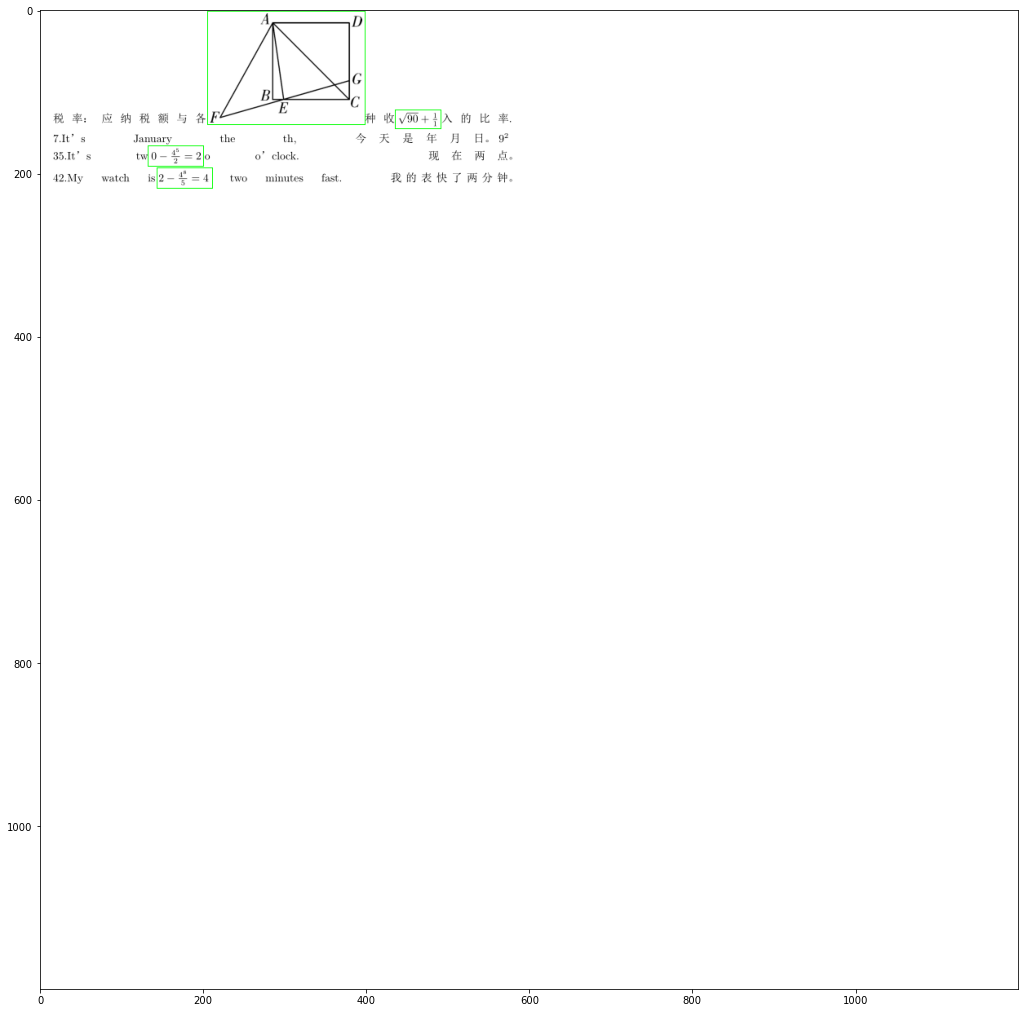

In [13]:
fig = plt.figure(figsize=(20,18))
detections = y.data

print(detections.size())
k = 0
i = 2
j = 0
recognized_boxes = []
recognized_scores = []
while j < detections.size(1) and detections[k, i, j, 0] >= 0.45:
    score = detections[k, i, j, 0]
    print('score :', score)
    pt = (detections[k, i, j, 1:] * args.window).cpu().numpy()
    coords = (int(pt[0]), int(pt[1]), int(pt[2]), int(pt[3]))
    recognized_boxes.append(coords)
    recognized_scores.append(score.cpu().numpy())
    j += 1

print(recognized_boxes)
for box in recognized_boxes:
    cv2.rectangle(cropped_image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 1)
plt.imshow(cropped_image)
plt.show()